In [82]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import nltk

import seaborn as sns


## This files cleans the different files needed to get the description of a character (Character Type) and it's gender

In [57]:
dataPath = '../../data/MovieSummaries/'
df_summaries = pd.read_csv( dataPath + 'plot_summaries.txt', sep='\t', header=None, names=['id', 'resume'])
df_name_cluster = pd.read_csv( dataPath + 'name.clusters.txt', sep='\t', header=None, names=['Character Name', 'ID'])
df_tvtropes_cluster = pd.read_csv( dataPath + 'tvtropes.clusters.txt', sep='\t', header=None, names=['Character Type', 'ID'])

In [58]:
# Extract character details from the ID column, ID in JSON format
def character_details(row):
    character_info = json.loads(row['ID'])
    return pd.Series({
        'Character Name': character_info.get('char'),
        'Movie': character_info.get('movie'),
        'ID': character_info.get('id'),
        'Actor': character_info.get('actor')
    })

character_details_df = df_tvtropes_cluster.apply(character_details, axis=1)
df_tvtropes_detail = pd.concat([df_tvtropes_cluster[['Character Type']], character_details_df], axis=1)
df_tvtropes_detail.head(2)

,Character Type,Character Name,Movie,ID,Actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane


In [59]:
#load movie.metadata.tsv
movie_metadata_df = pd.read_csv(
    dataPath + 'movie.metadata.tsv',
    sep='\t',
    names=[
        'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Release_date', 
        'Box_office_revenue', 'Runtime', 'Languages', 'Countries', 'Genres'
    ],
    encoding='utf-8'
)

# Load character.metadata.tsv
character_metadata_df = pd.read_csv(
    dataPath + 'character.metadata.tsv',
    sep='\t',
    names=[
        'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Release_date', 'Character_name', 
        'Actor_DOB', 'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name', 
        'Actor_age_at_release', 'Freebase_char_actor_map_ID', 'Freebase_character_ID', 
        'Freebase_actor_ID'
    ],
    encoding='utf-8'
)

C:\Users\laeti\AppData\Local\Temp\ipykernel_21220\3329848000.py:2: DtypeWarning: Columns (0,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata_df = pd.read_csv(
C:\Users\laeti\AppData\Local\Temp\ipykernel_21220\3329848000.py:13: DtypeWarning: Columns (0,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  character_metadata_df = pd.read_csv(


In [60]:
# Clean the way countries are listed
movie_metadata_df['Countries'] = movie_metadata_df['Countries'].str.replace(r'/m/\w+":\s*"([^"]+)"', r'\1', regex=True)

# Remove any remaining extra characters like commas and quotes after initial replace
movie_metadata_df['Countries'] = movie_metadata_df['Countries'].str.replace(r'"\s*,\s*"', ', ', regex=True)

# Remove quotation marks and braces
movie_metadata_df['Countries'] = movie_metadata_df['Countries'].str.replace(r'[{"}]', '', regex=True)
movie_metadata_df['Countries'] = movie_metadata_df['Countries'].str.replace(r'\s*,\s*"', ', ', regex=True)

countries_list = movie_metadata_df['Countries'].unique()

#problem of different names for the same country

In [61]:
# Clean the way countries are listed
movie_metadata_df['Genres'] = movie_metadata_df['Genres'].str.replace(r'/m/\w+":\s*"([^"]+)"', r'\1', regex=True)

movie_metadata_df['Genres'] = movie_metadata_df['Genres'].str.replace(r'"\s*,\s*"', ', ', regex=True)

movie_metadata_df['Genres'] = movie_metadata_df['Genres'].str.replace(r'[{"}]', '', regex=True)
movie_metadata_df['Genres'] = movie_metadata_df['Genres'].str.replace(r'\s*,\s*"', ', ', regex=True)

In [62]:
character_metadata_types = character_metadata_df.groupby('Actor_name')['Character_name'].unique()
character_metadata_types  = character_metadata_types.apply(lambda x: len(x)).sort_values(ascending=False)

In [63]:
#get all character types per actor
actor_character_types = df_tvtropes_detail.groupby('Actor')['Character Type'].unique()
df_tvtropes_detail["Character Type"] = df_tvtropes_detail["Character Type"].str.replace('_', ' ')
df_tvtropes_detail.head(2)

,Character Type,Character Name,Movie,ID,Actor
0,absent minded professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent minded professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane


In [64]:
character_metadata_df['Actor_DOB']

0         Actor date of birth
1                  1958-08-26
2                  1974-08-15
3                  1969-06-15
4                  1967-09-12
                 ...         
450665                1970-05
450666             1965-04-12
450667             1941-11-18
450668                    NaN
450669                    NaN
Name: Actor_DOB, Length: 450670, dtype: object

In [66]:
# Convert Release_date and Actor_DOB to datetime with errors are NaN
character_metadata_df['Release_date'] = pd.to_datetime(character_metadata_df['Release_date'], errors='coerce')
character_metadata_df['Actor_DOB'] = pd.to_datetime(character_metadata_df['Actor_DOB'], errors='coerce')

# Extract year, month, and day from Release_date
character_metadata_df['Release_year'] = character_metadata_df['Release_date'].dt.year
character_metadata_df['Release_month'] = character_metadata_df['Release_date'].dt.month
character_metadata_df['Release_day'] = character_metadata_df['Release_date'].dt.day

# Extract year, month, and day from Actor_DOB
character_metadata_df['Actor_DOB_year'] = character_metadata_df['Actor_DOB'].dt.year
character_metadata_df['Actor_DOB_month'] = character_metadata_df['Actor_DOB'].dt.month
character_metadata_df['Actor_DOB_day'] = character_metadata_df['Actor_DOB'].dt.day

In [67]:
#check gender values
gender = character_metadata_df['Actor_gender'].value_counts()
gender

Actor_gender
M               270257
F               134803
Actor gender         1
Name: count, dtype: int64

# clean height values

In [68]:
#describe height of actors, check values
height = character_metadata_df['Actor_height'].value_counts()
height.describe()

count     396.000000
mean      390.972222
std      1088.540906
min         1.000000
25%         5.000000
50%        26.500000
75%       194.000000
max      7180.000000
Name: count, dtype: float64

In [69]:
character_metadata_df['Actor_height'] = pd.to_numeric(character_metadata_df['Actor_height'], errors='coerce')

In [70]:
#value over 250 are not possible, remove them
character_metadata_df = character_metadata_df[character_metadata_df['Actor_height'] < 250]
character_metadata_df['Actor_height'].describe()

count    154813.000000
mean          1.752783
std           0.912266
min           0.610000
25%           1.676400
50%           1.750000
75%           1.830000
max         180.000000
Name: Actor_height, dtype: float64

In [71]:
#if the height is less than 250, it is probably in m --> we convert it to cm
character_metadata_df['Actor_height'] = np.where(character_metadata_df['Actor_height'] < 2.5, character_metadata_df['Actor_height']*100, character_metadata_df['Actor_height'])
character_metadata_df['Actor_height'].describe()

count    154813.000000
mean        174.817854
std          10.624813
min          61.000000
25%         167.640000
50%         175.000000
75%         183.000000
max         235.600000
Name: Actor_height, dtype: float64

Text(0.5, 1.0, 'Boxplot of Actor Height by gender')

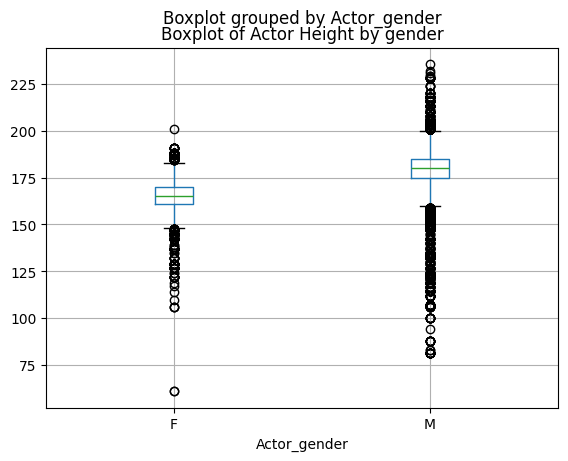

In [72]:
#boxplot of height based on gender to check data distribution
character_metadata_df.boxplot(column='Actor_height', by='Actor_gender')
plt.title('Boxplot of Actor Height by gender')

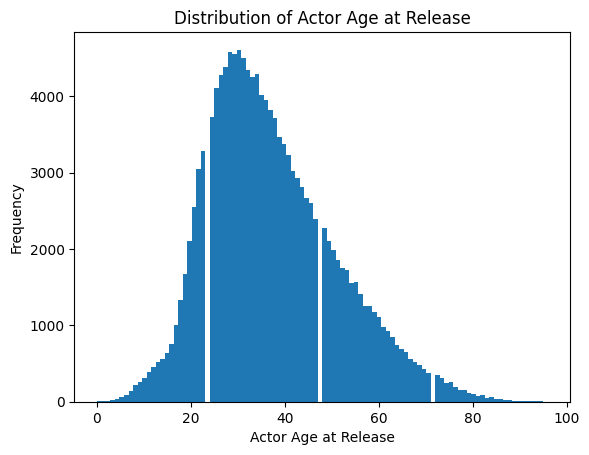

In [73]:
#print size of actor_age_at_release < 0 --> not possible
character_metadata_df['Actor_age_at_release']= pd.to_numeric(character_metadata_df['Actor_age_at_release'], errors='coerce')
strange = character_metadata_df[character_metadata_df['Actor_age_at_release'] < 0]
#drop lines with actor_age_at_release < 0 --> certainly inversion of birth and release date
character_metadata_df = character_metadata_df[character_metadata_df['Actor_age_at_release'] >= 0]
plt.hist(character_metadata_df['Actor_age_at_release'], bins=100)
plt.title('Distribution of Actor Age at Release')
plt.xlabel('Actor Age at Release')
plt.ylabel('Frequency')
plt.show()

In [74]:
character_metadata_df['Actor_age_at_release'].describe()

count    139646.000000
mean         37.339867
std          13.807819
min           0.000000
25%          27.000000
50%          35.000000
75%          46.000000
max          96.000000
Name: Actor_age_at_release, dtype: float64

In [75]:
#first film in 1888 so okey range
character_metadata_df['Release_year'].describe() 


count    139646.000000
mean       1991.684696
std          19.519789
min        1909.000000
25%        1984.000000
50%        1999.000000
75%        2006.000000
max        2016.000000
Name: Release_year, dtype: float64

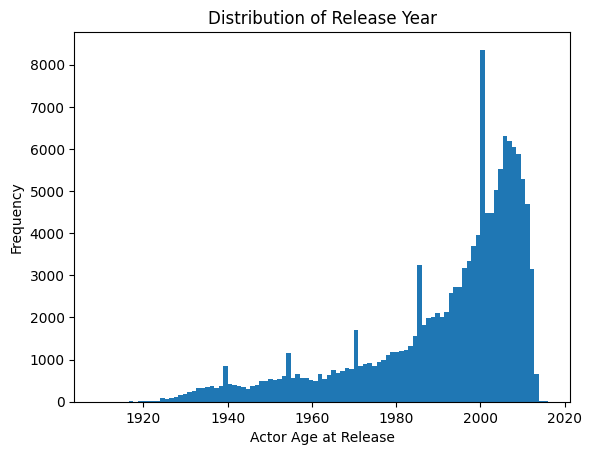

In [76]:
plt.hist(character_metadata_df['Release_year'], bins=100)
plt.title('Distribution of Release Year')
plt.xlabel('Actor Age at Release')
plt.ylabel('Frequency')
plt.show()

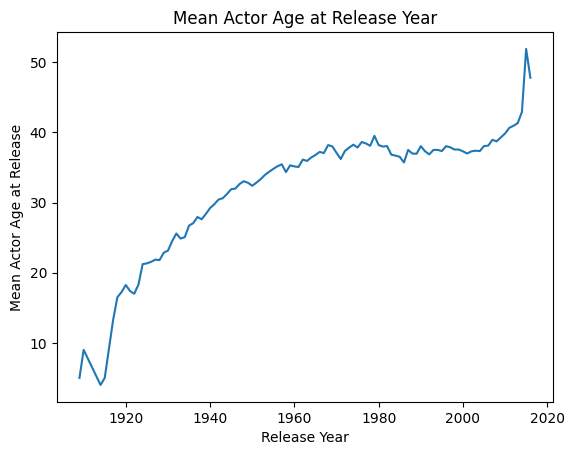

In [77]:
#plot mean age of actors at release year
mean_age = character_metadata_df.groupby('Release_year')['Actor_age_at_release'].mean()
plt.plot(mean_age)
plt.title('Mean Actor Age at Release Year')
plt.xlabel('Release Year')
plt.ylabel('Mean Actor Age at Release')
plt.show()

## After having cleaner data, we merge the different datasets to get the one desired

In [78]:
# Merge character metadata with summaries on Wikipedia_movie_ID/id
character_movie_data = character_metadata_df.merge(movie_metadata_df, left_on="Wikipedia_movie_ID", right_on="Wikipedia_movie_ID", how="inner")

#only keep Wikipedia_movie_ID, Freebase_movie_ID_x, Character_name, Actor_name, Actor_age_at_release, Actor_gender, Actor_height, Actor_ethnicity, Age_at_release, Countries
character_movie_data = character_movie_data[['Wikipedia_movie_ID', 'Freebase_movie_ID_x',
       'Character_name', 'Actor_gender', 'Actor_height',
       'Actor_ethnicity', 'Actor_name', 'Actor_age_at_release',
       'Freebase_char_actor_map_ID', 'Freebase_character_ID',
     'Release_year', 'Actor_DOB_year', 'Movie_name', 'Countries', 'Genres']]


# Merge with tropes detail on character name or Freebase_character_ID (if IDs are compatible)
character_full_description = character_movie_data.merge(df_tvtropes_detail, left_on="Freebase_char_actor_map_ID", right_on="ID", how="inner")
character_full_description.columns

character_full_description = character_full_description[['Wikipedia_movie_ID', 'Freebase_movie_ID_x', 'Character_name',
       'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name',
       'Actor_age_at_release', 'Freebase_char_actor_map_ID',
       'Freebase_character_ID', 'Release_year', 'Actor_DOB_year', 'Movie_name',
       'Countries', 'Genres', 'Character Type', 'Movie']]

In [79]:
# Merge with tropes detail on character name or Freebase_character_ID (if IDs are compatible)
character_name_only = character_movie_data.merge(df_tvtropes_detail, left_on="Actor_name", right_on="Actor", how="inner")
character_name_only.columns

Index(['Wikipedia_movie_ID', 'Freebase_movie_ID_x', 'Character_name',
       'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name',
       'Actor_age_at_release', 'Freebase_char_actor_map_ID',
       'Freebase_character_ID', 'Release_year', 'Actor_DOB_year', 'Movie_name',
       'Countries', 'Genres', 'Character Type', 'Character Name', 'Movie',
       'ID', 'Actor'],
      dtype='object')

In [80]:
# Merge with tropes detail on character name or Freebase_character_ID (if IDs are compatible)
character_name_only = character_movie_data.merge(df_tvtropes_detail, left_on="Actor_name", right_on="Actor", how="inner")
character_name_only.columns

character_name_only = character_name_only[['Character Name',
       'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_name',
       'Actor_DOB_year', 'Character Type']]

In [81]:
male_characters = character_name_only[character_name_only["Actor_gender"] == 'M']
female_characters = character_name_only[character_name_only["Actor_gender"] == 'F']

#count number of male and female
print("Number of Male Characters: ", len(male_characters), " Number of female characters" , len(female_characters))

Number of Male Characters:  5534  Number of female characters 487


C:\Users\laeti\AppData\Local\Temp\ipykernel_21220\2921476823.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(male_characters['Actor_height'], color='cornflowerblue', label='Male', shade=True)
C:\Users\laeti\AppData\Local\Temp\ipykernel_21220\2921476823.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(female_characters['Actor_height'], color='seagreen', label='Female', shade=True)


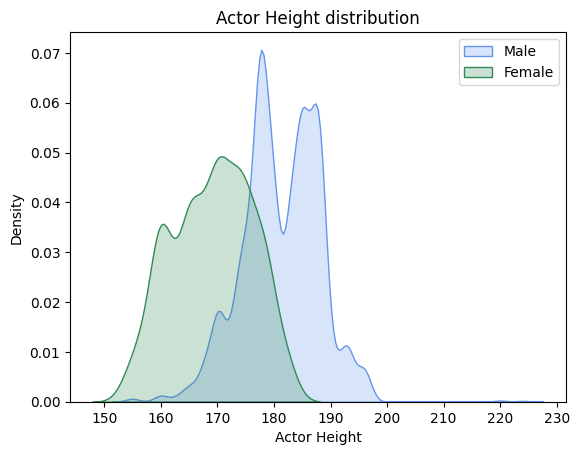

In [85]:

import seaborn as sns

# Plot KDE for male and female actor ages at release
sns.kdeplot(male_characters['Actor_height'], color='cornflowerblue', label='Male', shade=True)
sns.kdeplot(female_characters['Actor_height'], color='seagreen', label='Female', shade=True)

# Add labels and title
plt.title('Actor Height distribution')
plt.xlabel('Actor Height')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

In [87]:
female_characters['Actor_DOB_year'].describe()

count       7.000000
mean     1951.428571
std        29.714515
min      1908.000000
25%      1934.500000
50%      1958.000000
75%      1973.000000
max      1979.000000
Name: Actor_DOB_year, dtype: float64

In [88]:
def count_words(text):
    # Split the text into words and return the length of the list
    return len(text.split())

In [90]:
#generate one text with all the words contained in the character descriptions
male_characters = character_name_only[character_name_only["Actor_gender"] == 'M']
female_characters = character_name_only[character_name_only["Actor_gender"] == 'F']

male_characters["word_count"] = male_characters['Character Type'].apply(count_words)
female_characters["word_count"] = female_characters['Character Type'].apply(count_words)



Male_all_text = ' '.join(male_characters['Character Type'])
Female_all_text =  " ".join(review for review in female_characters['Character Type'])

C:\Users\laeti\AppData\Local\Temp\ipykernel_21220\3010502312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_characters["word_count"] = male_characters['Character Type'].apply(count_words)
C:\Users\laeti\AppData\Local\Temp\ipykernel_21220\3010502312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_characters["word_count"] = female_characters['Character Type'].apply(count_words)


In [91]:
male_characters.head(2)

,Character Name,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_DOB_year,Character Type,word_count
0,Frank Martin,M,175.0,NaN,Jason Statham,1967.0,consummate professional,2
1,Max Zorin,M,183.0,/m/01qhm_,Christopher Walken,1943.0,corrupt corporate executive,3


In [92]:
female_characters.head(2)

,Character Name,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_DOB_year,Character Type,word_count
2,Jen Yu,F,163.0,NaN,Zhang Ziyi,1979.0,arrogant kungfu guy,3
5,Margo Channing,F,160.0,NaN,Bette Davis,1908.0,prima donna,2


In [95]:
#save files 
save_folder = '../../data/clean/'
male_characters.to_csv(save_folder + 'male_character_description.txt', sep=',', index=False)
female_characters.to_csv(save_folder + 'female_character_description.txt', sep=',', index=False)